### 1. Import dependencies

In [1]:
import os
import copy
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
import torch

from torchvision import datasets, models, transforms

import torch.nn as nn
import torch.optim as optim

In [3]:
torch.__version__

'0.4.1'

### 2. Create PyTorch data generators

In [4]:
data_dir_train = 'data/train'
data_dir_validation = 'data/validation'

img_size = 224
batch_size = 32
epochs = 3

In [5]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transform = transforms.Compose([
                    transforms.Resize((img_size,img_size)),
                    transforms.ToTensor(),
                    normalize])

image_datasets = {
    'train': 
    datasets.ImageFolder(data_dir_train, data_transform),
    'validation': 
    datasets.ImageFolder(data_dir_validation, data_transform)
}

dataloaders = {
    phase: torch.utils.data.DataLoader(image_datasets[phase],
                                       batch_size=batch_size,
                                       shuffle=True, num_workers=4)
    for phase in ['train', 'validation']
}

dataset_sizes = {phase: len(image_datasets[phase])
                 for phase in ['train', 'validation']}

### 3. Import pre-trained ResNet50 and stack trainable layers on top of it

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Wrap this in a function so we can easily make the model structure object in '6. Load the best model checkpoint and evaluate it on a sample image'.
# Note that newly constructed modules are trainable (requires_grad=True) by default.
def net():
    model = models.resnet50(pretrained=True).to(device)
    
    for param in model.parameters():
        param.requires_grad = False   
    
    model.fc = nn.Sequential(
                nn.Linear(2048, 128),
                nn.ReLU(inplace=True),
                nn.Linear(128, 2)).to(device)
    return model

In [7]:
model = net()

### 4. Train the model and save it


In [8]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.RMSprop(model.fc.parameters())

In [9]:
model_checkpoint_path = 'saved_models/pytorch/weights.hdf5'

In [10]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward - track history only in train mode
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
            
    torch.save(model.state_dict(), model_checkpoint_path)
    return model

In [11]:
model_trained = train_model(model, criterion, optimizer, num_epochs=epochs)

Epoch 1/3
----------
train loss: 67.7876, acc: 0.5850
validation loss: 14.1315, acc: 0.5100
Epoch 2/3
----------
train loss: 2.4457, acc: 0.8314
validation loss: 1.0189, acc: 0.8750
Epoch 3/3
----------
train loss: 3.6794, acc: 0.8357
validation loss: 0.8225, acc: 0.9000


### 5. Load the model checkpoint

In [12]:
loaded_model = net()
loaded_model.load_state_dict(torch.load(model_checkpoint_path))

### 7. Evaluate the model on sample test images

In [42]:
validation_img_paths = ["data/validation/alien/11.jpg",
                        "data/validation/alien/22.jpg",
                        "data/validation/predator/33.jpg"]
img_list = [Image.open(img_path) for img_path in validation_img_paths]

In [43]:
validation_batch = torch.stack([data_transform(img).to(device)
                                for img in img_list])

In [44]:
pred_logits_tensor = model(validation_batch)
pred_probs = nn.functional.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()

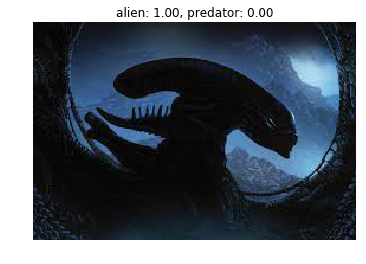

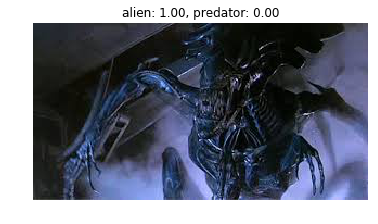

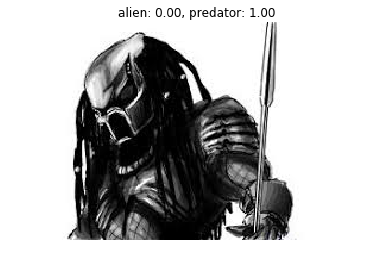

In [45]:
for i, img in enumerate(img_list):
    plt.figure()
    plt.axis('off')
    plt.title("alien: {:.2f}, predator: {:.2f}".format(pred_probs[i,0], 
                                                       pred_probs[i,1]))
    plt.imshow(img)